In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import io
import glob
import clip  # OpenAI's CLIP package
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
gpu_id = 5  # Change this to select a different GPU
device = f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu"


In [4]:
# Define the transformations
# Function to apply JPEG compression artifacts to PNG images
def apply_jpeg_artifacts(img, quality=75):
    buffer = io.BytesIO()
    img.save(buffer, format="JPEG", quality=quality)  # Convert PNG to JPEG in memory
    return Image.open(buffer)


# Define transformations (data augmentation + normalization)
def get_transforms():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to ResNet-50 input size
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform

In [5]:
# Custom dataset
class CLIPImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, USE_DFT=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.USE_DFT=USE_DFT

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image_np = np.array(image)

        if self.USE_DFT:
            image_np = np.array(image)
            dft = np.fft.fft2(image_np, axes=(0, 1))
            dft_shifted = np.fft.fftshift(dft)
            magnitude_spectrum = 20 * np.log(np.abs(dft_shifted) + 1)
            image_np = np.uint8(np.clip(magnitude_spectrum, 0, 255))
            image = Image.fromarray(image_np.astype(np.uint8))

        if self.transform != None:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

In [6]:
# # Simple linear head for classification
# class CLIPClassifier(nn.Module):
#     def __init__(self, clip_model, num_classes=11):
#         super().__init__()
#         self.clip_model = clip_model
#         self.classifier = nn.Sequential(
#                             nn.LayerNorm(512),
#                             nn.Linear(512, 128),
#                             nn.ReLU(),
#                             nn.Linear(128, num_classes)
#                             )

#     def forward(self, x):
#         with torch.no_grad():
#             features = self.clip_model.encode_image(x)
#         features = features.float()
#         return self.classifier(features)

In [7]:
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes=11):
        super().__init__()
        self.clip_model = clip_model
        self.classifier = nn.Sequential(
                            nn.LayerNorm(512),
                            nn.Linear(512, 128),
                            nn.ReLU(),
                            nn.Linear(128, num_classes)
                            )

    def forward(self, x):
        with torch.no_grad():
            features = self.clip_model.encode_image(x)
        features = features.float()
        return self.classifier(features)

In [8]:
def get_datsets(transform, USE_DFT = False):
    # Define the file paths for training set
    file_paths = [
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/ADM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/DDPM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/Diff-ProjectedGAN/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/Diff-StyleGAN2/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/IDDPM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/LDM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/PNDM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/ProGAN/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/ProjectedGAN/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/StyleGAN/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/train/Real/0_real/*.jpg'
    ]

    label_ADM = 0
    label_DDPM = 1
    label_Diff_Pro_GAN = 2
    label_Diff_Style_GAN = 3
    label_IDDPM = 4
    label_LDM = 5
    label_PNDM = 6
    label_ProGAN = 7
    label_ProjectedGAN = 8
    label_StyleGAN = 9
    label_Real = 10

    # List of labels
    labels = [label_ADM, label_DDPM, label_Diff_Pro_GAN, label_Diff_Style_GAN, label_IDDPM, label_LDM, label_PNDM, label_ProGAN, label_ProjectedGAN, label_StyleGAN, label_Real]


    # Collect all image paths and corresponding labels
    image_paths = []
    image_labels = []

    for path, label in zip(file_paths, labels):
        images = glob.glob(path)  # Get all image file paths in the folder
        image_paths.extend(images)
        image_labels.extend([label] * len(images))  # Assign the same label to all images in that folder

    # Check if images and labels are aligned
    assert len(image_paths) == len(image_labels)

    # Example usage
    dataset = CLIPImageDataset(image_paths, image_labels, transform, USE_DFT)

    # Define the file paths for validation set
    # Define the file paths for training set
    val_file_paths = [
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/ADM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/DDPM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/Diff-ProjectedGAN/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/Diff-StyleGAN2/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/IDDPM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/LDM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/PNDM/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/ProGAN/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/ProjectedGAN/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/StyleGAN/1_fake/*.png',
        '/data/home/saisuchithm/godwin/mlsp/project/diffusion_model_deepfakes_lsun_bedroom/val/Real/0_real/*.jpg'
    ]

    label_ADM = 0
    label_DDPM = 1
    label_Diff_Pro_GAN = 2
    label_Diff_Style_GAN = 3
    label_IDDPM = 4
    label_LDM = 5
    label_PNDM = 6
    label_ProGAN = 7
    label_ProjectedGAN = 8
    label_StyleGAN = 9
    label_Real = 10

    # List of labels
    val_labels = [label_ADM, label_DDPM, label_Diff_Pro_GAN, label_Diff_Style_GAN, label_IDDPM, label_LDM, label_PNDM, label_ProGAN, label_ProjectedGAN, label_StyleGAN, label_Real]

    # Collect all image paths and corresponding labels
    val_image_paths = []
    val_image_labels = []

    for path, label in zip(val_file_paths, val_labels):
        images = glob.glob(path)  # Get all image file paths in the folder
        val_image_paths.extend(images)
        val_image_labels.extend([label] * len(images))

    # Check if images and labels are aligned
    assert len(val_image_paths) == len(val_image_labels)

    val_dataset = CLIPImageDataset(val_image_paths, val_image_labels, transform, USE_DFT)

    return dataset, val_dataset

In [9]:
class EarlyStopping:
    def __init__(self, model, patience=5, min_delta=0.001):
        """
        Args:
            patience (int): Number of epochs to wait after last improvement.
            min_delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False
        self.model = model

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if loss improves
            self.model = model
        else:
            self.counter += 1  # Increase counter if no improvement
            if self.counter >= self.patience:
                self.early_stop = True


In [10]:
# Training Loop
def train_CLIP(model, train_dummy_loader, val_dummy_loader, criterion, optimizer, num_epochs):
    early_stopping = EarlyStopping(model,patience=3, min_delta=0.001)
    training_loss_list = []
    training_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    checkpoint_dir = "/data/home/saisuchithm/godwin/mlsp/project/checkpoints"
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_accuracy = 0
        for batch_idx, (images, labels) in enumerate(train_dummy_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            predicted = torch.argmax(outputs, dim=1)
            #Calcualte the accuracy
            accuracy = (predicted == labels).sum().item() / len(labels)
            total_accuracy += accuracy
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            # ---- Save checkpoint ----
            checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{epoch+1}.pt")
            torch.save({
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_accuracy": avg_loss
            }, checkpoint_path)
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dummy_loader)}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}", end='\r')
            break
            if batch_idx > 2000:
                break

        avg_loss = total_loss / (batch_idx + 1)
        avg_accuracy = total_accuracy / (batch_idx + 1)
        training_loss_list.append(avg_loss)
        training_accuracy_list.append(avg_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.4f}", end='\r')

        # Validation 
        model.eval()
        with torch.no_grad():
            total_loss = 0.0
            total_accuracy = 0.0
            for val_idx, (images, labels) in enumerate(val_dummy_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss
                predicted = torch.argmax(outputs, dim=1)
                #Calcualte the accuracy
                accuracy = (predicted == labels).sum().item() / len(labels)
                total_accuracy += accuracy
                break
                if val_idx > 2000:
                    break
            avg_loss = total_loss / (val_idx + 1)
            avg_accuracy = total_accuracy / (val_idx + 1)
            val_loss_list.append(avg_loss)
            val_accuracy_list.append(accuracy)
            
            early_stopping(avg_loss, model)
            print(f"\nValidation Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}\n", end='\r')
            
            if early_stopping.early_stop:
                print("Early stopping triggered!")
                break
        

    return training_accuracy_list, training_loss_list, val_loss_list, val_accuracy_list, early_stopping.model


In [11]:
model, preprocess = clip.load("ViT-B/32", device=device)
# transform = get_transform()
dataset, val_dataset = get_datsets(transform = preprocess, USE_DFT=True)
batch_size = 32
lr = 1e-3
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# small_dataset = torch.utils.data.Subset(dataset, range(8))
# train_loader = DataLoader(small_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

classifier = CLIPClassifier(model).to(device)
optimizer = torch.optim.Adam(classifier.classifier.parameters(), lr=lr, weight_decay=0.1 * lr)
criterion = nn.CrossEntropyLoss()

In [12]:
label_idx_to_name = {
    0: "Picture of AI generated image, from ADM method",
    1: "Picture of AI generated image, from DDPM method",
    2: "Picture of AI generated image, from Diff-ProjectedGAN method",
    3: "Picture of AI generated image, from Diff-StyleGAN",
    4: "Picture of AI generated image, from IDDPM method",
    5: "Picture of AI generated image, from LDM method",
    6: "Picture of AI generated image, from PNDM method",
    7: "Picture of AI generated image, from ProGAN method",
    8: "Picture of AI generated image, from ProjectedGAN method",
    9: "Picture of AI generated image, from StyleGAN method",
    10: "Picture of a Real Image"
}
from collections import Counter

print(f"\nNumber of datapoints per label in training set")
label_counts = Counter(dataset.labels)
for label, count in label_counts.items():
    print(f"{label_idx_to_name.get(label)}: {count} images")


print(f"\nNumber of datapoints per label in validation set")
label_counts = Counter(val_dataset.labels)
for label, count in label_counts.items():
    print(f"{label_idx_to_name.get(label)}: {count} images")


Number of datapoints per label in training set
Picture of AI generated image, from ADM method: 39000 images
Picture of AI generated image, from DDPM method: 39000 images
Picture of AI generated image, from Diff-ProjectedGAN method: 39000 images
Picture of AI generated image, from Diff-StyleGAN: 39000 images
Picture of AI generated image, from IDDPM method: 39000 images
Picture of AI generated image, from LDM method: 39000 images
Picture of AI generated image, from PNDM method: 39000 images
Picture of AI generated image, from ProGAN method: 39000 images
Picture of AI generated image, from ProjectedGAN method: 39000 images
Picture of AI generated image, from StyleGAN method: 39000 images
Picture of a Real Image: 39000 images

Number of datapoints per label in validation set
Picture of AI generated image, from ADM method: 1000 images
Picture of AI generated image, from DDPM method: 1000 images
Picture of AI generated image, from Diff-ProjectedGAN method: 1000 images
Picture of AI generat

In [ ]:
# training_accuracy_list, training_loss_list, val_loss_list, val_accuracy_list, model_trainined = train_CLIP(model=classifier,
#                                                                                                     train_dummy_loader=train_loader,
#                                                                                                     val_dummy_loader=val_loader,
#                                                                                                     criterion=criterion,
#                                                                                                     optimizer=optimizer,
#                                                                                                     num_epochs=1)


Epoch 1/1, Average Loss: 0.0002, Average Accuracy: 0.0000000
Validation Loss: 0.0057, Accuracy: 0.0028


In [ ]:
# model_name = "Trained_CLIP"
# torch.save(model_trainined.state_dict(), "/data/home/saisuchithm/godwin/mlsp/project" + model_name + ".pth")

In [1]:
del classifier
del train_loader
del val_loader
del optimizer
del criterion
# del model_trainined

NameError: name 'classifier' is not defined

In [3]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()


### Testing on the Validation dataset for each class

In [13]:
classifier = CLIPClassifier(model).to(device)
classifier.load_state_dict(torch.load("/data/home/saisuchithm/godwin/mlsp/project/Trained_CLIP_final.pth", weights_only=True))
classifier.eval()

CLIPClassifier(
  (clip_model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQu

In [14]:
_, val_dataset = get_datsets(transform = preprocess, USE_DFT=False)
accuracy_class = []
for i in range(11):
    first_index = i*1000
    last_index = (i+1)*1000
    accuracy = 0
    print(f"Running for {label_idx_to_name.get(i)}")
    for j in range(first_index, last_index):
      image = val_dataset[j][0]
      label = val_dataset[j][1]
      image = image.unsqueeze(0)
      image = image.to(device)
      label = torch.tensor([label]).to(device)
      output = classifier(image)
      predicted = torch.argmax(output, dim=1)
      if predicted == label:
        accuracy += 1
    accuracy_class.append(accuracy/1000)
print(accuracy_class)

Running for Picture of AI generated image, from ADM method
Running for Picture of AI generated image, from DDPM method
Running for Picture of AI generated image, from Diff-ProjectedGAN method
Running for Picture of AI generated image, from Diff-StyleGAN
Running for Picture of AI generated image, from IDDPM method
Running for Picture of AI generated image, from LDM method
Running for Picture of AI generated image, from PNDM method
Running for Picture of AI generated image, from ProGAN method
Running for Picture of AI generated image, from ProjectedGAN method
Running for Picture of AI generated image, from StyleGAN method
Running for Picture of a Real Image
[0.7, 0.969, 0.878, 0.971, 0.852, 0.92, 0.971, 0.972, 0.808, 0.992, 0.929]


In [15]:
label_idx_to_name = {
    0: "Picture of AI generated image, from ADM method",
    1: "Picture of AI generated image, from DDPM method",
    2: "Picture of AI generated image, from Diff-ProjectedGAN method",
    3: "Picture of AI generated image, from Diff-StyleGAN",
    4: "Picture of AI generated image, from IDDPM method",
    5: "Picture of AI generated image, from LDM method",
    6: "Picture of AI generated image, from PNDM method",
    7: "Picture of AI generated image, from ProGAN method",
    8: "Picture of AI generated image, from ProjectedGAN method",
    9: "Picture of AI generated image, from StyleGAN method",
    10: "Picture of a Real Image"
}
print("Results of CLIP Model")
for i in range(len(accuracy_class)):
    print(f"Accuracy for {label_idx_to_name.get(i)} : {accuracy_class[i]}")

Results of CLIP Model
Accuracy for Picture of AI generated image, from ADM method : 0.7
Accuracy for Picture of AI generated image, from DDPM method : 0.969
Accuracy for Picture of AI generated image, from Diff-ProjectedGAN method : 0.878
Accuracy for Picture of AI generated image, from Diff-StyleGAN : 0.971
Accuracy for Picture of AI generated image, from IDDPM method : 0.852
Accuracy for Picture of AI generated image, from LDM method : 0.92
Accuracy for Picture of AI generated image, from PNDM method : 0.971
Accuracy for Picture of AI generated image, from ProGAN method : 0.972
Accuracy for Picture of AI generated image, from ProjectedGAN method : 0.808
Accuracy for Picture of AI generated image, from StyleGAN method : 0.992
Accuracy for Picture of a Real Image : 0.929


### GradCam 
Define a class to store and analyse the gradients

In [65]:
class GradCam:
  def __init__(self, model, target_layer):
    super(GradCam, self).__init__()
    self.model = model
    self.target_layer = target_layer
    self.gradients = None
    self.activations = None

    #Register the hooks 
    self.forward_hook_handle  = self.target_layer.register_forward_hook(self.forward_hook)
    self.backward_hook_handle  = self.target_layer.register_full_backward_hook(self.backward_hook)
  
  def forward_hook(self, module, input, output):
    print("Forward hook triggered!")
    self.activations = output[0]
  
  def backward_hook(self, module, grad_in, grad_out):
    print("Backward hook triggered!")
    self.gradients = grad_out[0]

  def generate(self, input, target):
    self.model.zero_grad()
    output = self.model(input)
    loss = output[0, target]

    loss.backward()
    activations = self.activations.detach()
    gradients = self.gradients.detach()

    # Remove CLS token
    activations = activations[1:]  # [49, 768]
    gradients = gradients[1:]      # [49, 768]

    # Reshape to (7, 7, 768)
    h = w = 7
    activations = activations.reshape(h, w, -1)
    gradients = gradients.reshape(h, w, -1)

    # Compute weights
    weights = gradients.mean(dim=(0, 1))  # [768]

    # Weighted sum of activations
    cam = (activations * weights)  # [7, 7]
    cam = torch.mean(activations, dim=2)
    cam = torch.relu(cam)
    cam -= cam.min()
    cam /= cam.max()

    return cam.detach().cpu().numpy()
  
  def remove_hooks(self):
    # Call this when done to clean up
    self.forward_hook_handle.remove()
    self.backward_hook_handle.remove()

In [66]:
# Helper to overlay heatmap
def overlay_cam_on_image(img_pil, cam, alpha=0.5):
    # Handle if input is tensor
    if isinstance(img_pil, torch.Tensor):
        img_np = img_pil.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    else:
        img_np = np.array(img_pil) 
    cam = cam.astype(np.float32)
    # Make sure cam is normalized and resized to image dimensions
    cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
    cam_normalized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min() + 1e-8)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_normalized), cv2.COLORMAP_JET)

    # Convert heatmap to float for blending
    heatmap = np.float32(heatmap) / 255.0
    # img_np = np.float32(img_np) / 255.0

    # Blend heatmap and image
    overlay = alpha * heatmap + (1 - alpha) * img_np
    # overlay = np.clip(overlay, 0, 1)
    overlay = np.uint8(255 * overlay)
    return overlay

In [61]:
model, preprocess = clip.load("ViT-B/32", device=device)
# transform = get_transform()
dataset, val_dataset = get_datsets(transform = preprocess, USE_DFT=False)

classifier = CLIPClassifier(model).to(device)
classifier.load_state_dict(torch.load("/data/home/saisuchithm/godwin/mlsp/project/Trained_CLIP.pth", weights_only=True))
classifier.eval()

CLIPClassifier(
  (clip_model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQu

In [ ]:
target_layer = classifier.clip_model.visual.transformer.resblocks[-1].attn
#Define Gradcam object with the model and target layer
gradcam = GradCam(classifier, target_layer)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


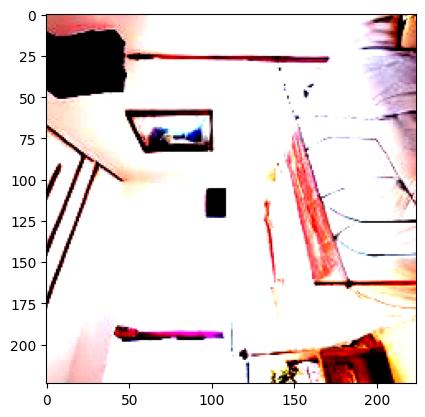

In [68]:
image = val_dataset[5000][0].to(device)
label = val_dataset[5000][1]
plt.imshow(image.cpu().T)


Forward hook triggered!
Forward hook triggered!
Backward hook triggered!
Backward hook triggered!


/tmp/ipykernel_2305500/2862566342.py:12: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam_normalized), cv2.COLORMAP_JET)


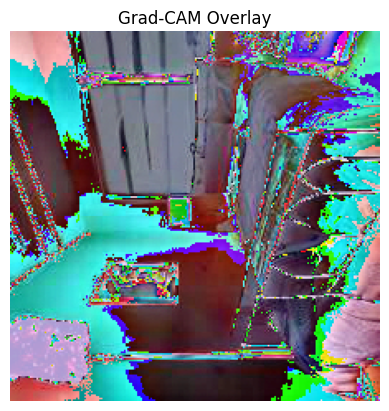

In [69]:
cam = gradcam.generate(image.unsqueeze(0), label)
overlay = overlay_cam_on_image(image, cam, alpha=0.2)
overlay = np.rot90(overlay, k=1)
plt.imshow(overlay)
plt.title("Grad-CAM Overlay")
plt.axis("off")
plt.show()

In [58]:
gradcam.remove_hooks()

In [70]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def overlay_cam_on_image(img_pil, cam, alpha=0.5):
    img_np = np.array(image.cpu().T)
    cam = cam.astype(np.float32)
    # Resize cam to image size
    cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
    cam_normalized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min() + 1e-8)
    
    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_normalized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255.0
    # img_np = np.float32(img_np) / 255.0

    # Overlay
    overlay = alpha * heatmap + (1 - alpha) * img_np
    overlay = np.uint8(255 * overlay)
    
    return overlay, heatmap, img_np

def plot_side_by_side(img_np, heatmap, overlay):
    plt.figure(figsize=(18, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.axis('off')
    plt.title('Original Image')

    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.axis('off')
    plt.title('Heatmap')

    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title('Overlayed Image')

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_2305500/3670951106.py:13: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam_normalized), cv2.COLORMAP_JET)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


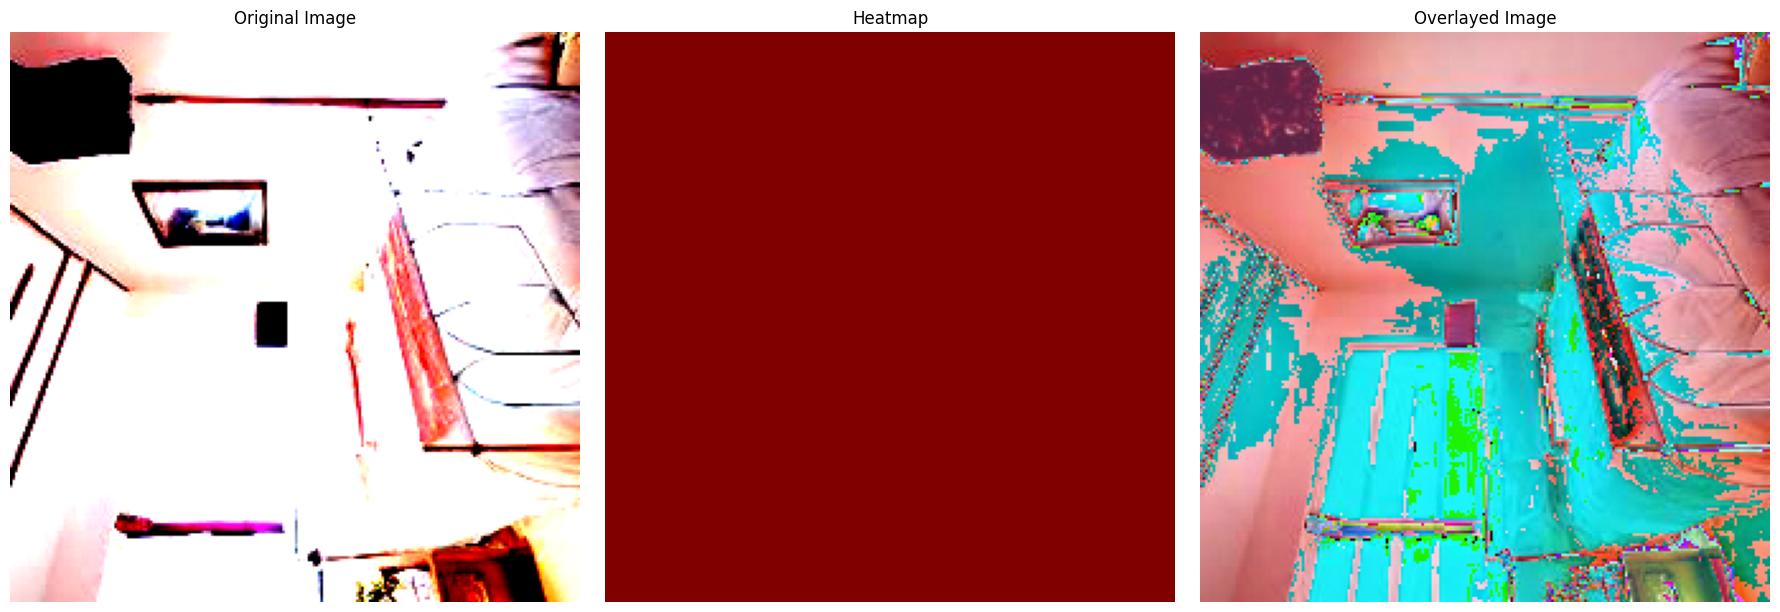

In [71]:
# Call your overlay function
overlay, heatmap, img_np = overlay_cam_on_image(image, cam)

# Plot all 3 side by side
plot_side_by_side(img_np, heatmap, overlay)

